In [5]:
import numpy as np
from scipy.stats import bernoulli

In [12]:
def initialize(K, B, min_mu_cost):
    """
    Parameters
    K - Number of arms
    B - Budget
    min_mu_cost - The minimum cost in the bernoulli trial
    Returns
    max_size - 2*B/min_cost
    N - A 2d array of size max_size and arms containing the total number of times an arm has been played at each time step
    X - A 2d array of size max_size and arms containing total reward obtained at each time step
    C - A 2d array of size max_size and arms containing total cost obtained at each time step
    arm_
    """
    max_size = int(2*B/min_mu_cost)
    N = np.zeros((max_size, K))
    X = np.zeros((max_size, K))
    C = np.zeros((max_size, K))
    arm_pulled = np.zeros(max_size, dtype = "int")
    return N,X,C,arm_pulled

def UCB_BV2(X, C, N, lam, t):
    #D_t = X[t]/C[t] + (1 + 1/(lam - np.sqrt(np.log(t)/N[t])))*np.sqrt(np.log(t)/N[t])*1/lam
    av_rew = X[t]/N[t]
    av_cost = C[t]/N[t]
    av_cost[(av_cost - 0) <= 1e-5] = 1e-10
    exploit = av_rew/av_cost
    sq_term = np.sqrt(np.log(t+1)/N[t])
    explore = (1 + 1/(lam - sq_term))*sq_term*1/lam
    #print(exploit)
    #print(explore)
    D_t = exploit+explore
    return np.argmax(D_t)
    
def UCB_with_budget_and_fair(K, B, reward_means, cost_means, alpha = None, R = None):
    """
    Parameters
    K - Number of arms
    B - Budget
    reward_means - An array bernoulli means for rewards
    cost_means - An array bernoulli means for costs
    """
    
    def update(N, X, C, t):
        N[t] = N[t-1]
        X[t] = X[t-1]
        C[t] = C[t-1]
                       
    min_mu_cost = min(cost_means)
    N, X, C, arm_pulled = initialize(K, B, min_mu_cost)
    
    ##Playing each arm atleast once
    for arm in range(K):
        if arm > 0:
            update(N, X, C, arm)
        N[arm][arm] += 1
        X[arm][arm] += bernoulli.rvs(reward_means[arm], size=1)[0]
        C[arm][arm] += bernoulli.rvs(cost_means[arm], size=1)[0]
        arm_pulled[arm] = arm
    
    t = K-1
    #print(B)
    B -= np.sum(C[t])
    #print(B)
    while B > 0:
        t = t + 1
        ave_costs = C[t-1]/N[t-1]
        lam = np.min(ave_costs) ##Hack
        lam = lam if(lam - 0) > 1e-5 else 0.05
        #print(lam)
        ###Fairness
        fair_penalty = np.zeros(K)
        if(alpha is not None and R is not None):
            fair_penalty = R*t - N[t-1] #T is the actual time step, its index represented by t-1
            if(np.max(fair_penalty) > alpha):
                arm = np.argmax(fair_penalty)
            else:
                arm = UCB_BV2(X, C, N, lam, t-1)
        else:        
            arm = UCB_BV2(X, C, N, lam, t-1)
        arm_pulled[t] = arm
        #print(t)
        update(N, X, C, t)
        N[t][arm] += 1
        X[t][arm] += bernoulli.rvs(reward_means[arm], size=1)[0]
        cost = bernoulli.rvs(cost_means[arm], size=1)[0]
        C[t][arm] += cost
        B -= cost
    return N,X,C,arm_pulled,t

In [7]:
def compute_regret(X, C, arm_pulled, tB, best_arm, cost_means, reward_means):
    """
    Returns 
    regret - an array size of tB+1 containing regret at each round
    #budget - total budget at end of round t
    """
    regret = np.zeros(tB+1)
    reg_sum = np.zeros(tB+1)
    budget_sum = np.zeros(tB+1)
    #budget = np.zeros(tB+1)
    for i in range(tB+1):
        #budget[i] = np.sum(C[t])
        arm = arm_pulled[i]
        regret[i] = cost_means[arm]*(reward_means[best_arm]/cost_means[best_arm] - reward_means[arm]/cost_means[arm])
        #regret[i] = reward_means[best_arm] - reward_means[arm]
        reg_sum[i] = (reg_sum[i-1] + regret[i]) if i > 0 else regret[i]

        budget_sum[i] = np.sum(C[i])
    return regret, reg_sum, budget_sum

In [14]:
k = 10
B = 10000
R = np.array([0.05]*k)
alpha = 10
#N,X,C = initialize(k, 100, 0.1)
reward_means = np.zeros(k)
# for i in range(k):
#     reward_means[i] = (0.8-0.01*i)
reward_means = np.random.rand(10)
#cost_means = np.random.rand(10)
#reward_means = np.zeros(10)
#reward_means[0] = 1
#cost_means = np.array([1.0]*10)
cost_means = np.random.choice(range(1,11), size = 10, replace = False)/10
N,X,C,arm_pulled,tB = UCB_with_budget_and_fair(k, B, reward_means, cost_means)
N2,X2,C2,arm_pulled2,tB2 = UCB_with_budget_and_fair(k, B, reward_means, cost_means, alpha, R)
best_arm = np.argmax(reward_means/cost_means)

# print(best_arm)
# print(arm_pulled[0:tB])
regret, reg_sum, budget_sum = compute_regret(X, C, arm_pulled, tB, best_arm, cost_means, reward_means)
regret2, reg_sum2, budget_sum2 = compute_regret(X2, C2, arm_pulled2, tB2, best_arm, cost_means, reward_means)

In [15]:
# regret_sum = np.zeros(tB)
# budget_sum = np.zeros(tB)
# for t in range(tB):
#     if t == 0:
#         regret_sum[t] = regret[t]
#     else:
#         regret_sum[t] = regret_sum[t-1] + regret[t]
#     budget_sum[t] = np.sum(C[t])
#print(arm_pulled)
#print(arm_pulled[1:40])
#print(regret[0:20])
print(tB)
print(tB2)
print(sum(regret))
print(sum(regret2))
#print(sum(C[tB]))
#print(np.sum(regret[0:tB+1]))

26027
23503
11433.925356608388
15902.074417626593


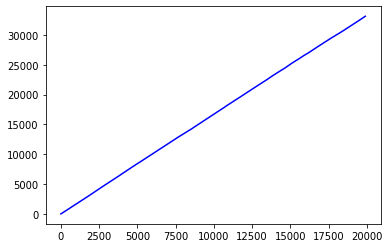

In [179]:
import matplotlib.pyplot as plt
interval = 100
match = lambda a, b: [ np.where(b == x)[0][0] if x in b else None for x in a ]
t = range(1, B, interval)
inds = match(t, budget_sum)

plt.plot(budget_sum[inds], reg_sum[inds], 'b-')

In [123]:
inds

[0,
 281,
 503,
 735,
 903,
 1107,
 1288,
 1463,
 1640,
 1799,
 1994,
 2169,
 2341,
 2562,
 2716,
 2868,
 3082,
 3238,
 3394,
 3578,
 3740,
 3901,
 4065,
 4231,
 4385,
 4571,
 4766,
 4958,
 5121,
 5280,
 5460,
 5646,
 5815,
 5989,
 6166,
 6336,
 6501,
 6678,
 6887,
 7048,
 7228,
 7389,
 7586,
 7769,
 7959,
 8126,
 8324,
 8505,
 8688,
 8869,
 9040,
 9223,
 9405,
 9587,
 9758,
 9940,
 10127,
 10321,
 10507,
 10664,
 10834,
 11003,
 11200,
 11380,
 11557,
 11734,
 11923,
 12109,
 12287,
 12474,
 12675,
 12874,
 13056,
 13245,
 13454,
 13662,
 13843,
 14029,
 14245,
 14433,
 14612,
 14793,
 14977,
 15166,
 15401,
 15621,
 15794,
 15977,
 16153,
 16370,
 16578,
 16777,
 16963,
 17129,
 17305,
 17493,
 17671,
 17849,
 18059,
 18237]